# **Sentimen Analisis Review APK Klik Indomaret Play Store**

In [104]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

!pip install sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from wordcloud import WordCloud

import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Conv1D, MaxPooling1D, SpatialDropout1D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading Dataset

In [4]:
reviews_df = pd.read_csv('ulasan_aplikasi_klikindo.csv')

In [5]:
# Menghitung jumlah baris dan kolom dalam DataFrame
reviews_df.shape

(47099, 11)

In [6]:
# Menampilkan lima baris pertama dari DataFrame app_reviews_df
reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,d74813b4-ef42-4670-9778-545a7333818a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Terimakasih atas kemudahan akses yang diberika...,5,57,2503200,2025-04-10 16:23:31,"Halo, Redmi Ujun. Terima kasih sudah berbelanj...",2025-04-10 16:30:11,2503200
1,a2b797cc-bfea-476d-ba9f-1aebb7e304c2,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,tolong kembalikan versi klik dulu. supaya gamp...,4,9,2503200,2025-04-12 10:42:54,"Halo, Lailatul B. Terima kasih sudah berbelanj...",2025-04-12 11:00:15,2503200
2,dfde30e2-a5ac-4e5d-b298-969cc93f07f9,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"aplikasinya sekarang parah, hari jumat 4 april...",1,84,2503200,2025-04-08 13:22:04,"Halo, Yuli Mifta. Mohon maaf atas kendala yang...",2025-04-08 13:30:13,2503200
3,4c1509a9-e4f9-498d-9886-5befbefde76d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,saya senang dg yg versi lama. bisa filter disk...,1,226,2501201,2025-01-16 13:24:25,"Halo, Mrakha ArR. Mohon maaf atas kendala yang...",2025-01-16 13:30:11,2501201
4,03cf3c55-342c-495b-a73f-07742f76d293,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Bintang nya sy turunin dulu ya krn versi yg ba...,2,124,2501202,2025-01-19 09:05:12,"Halo, trihastuti. Mohon maaf atas kendala yang...",2025-01-19 09:30:10,2501202


In [7]:
# Menampilkan informasi tentang DataFrame app_reviews_df
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47099 entries, 0 to 47098
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              47099 non-null  object
 1   userName              47099 non-null  object
 2   userImage             47099 non-null  object
 3   content               47098 non-null  object
 4   score                 47099 non-null  int64 
 5   thumbsUpCount         47099 non-null  int64 
 6   reviewCreatedVersion  38112 non-null  object
 7   at                    47099 non-null  object
 8   replyContent          36316 non-null  object
 9   repliedAt             36316 non-null  object
 10  appVersion            38112 non-null  object
dtypes: int64(2), object(9)
memory usage: 4.0+ MB


In [8]:
# df yang berisi hanya content
content_reviews_df = reviews_df[['content']]

In [9]:
content_reviews_df.head()

,content
0,Terimakasih atas kemudahan akses yang diberika...
1,tolong kembalikan versi klik dulu. supaya gamp...
2,"aplikasinya sekarang parah, hari jumat 4 april..."
3,saya senang dg yg versi lama. bisa filter disk...
4,Bintang nya sy turunin dulu ya krn versi yg ba...


In [10]:
clean_df = content_reviews_df.copy()

In [11]:
clean_df.duplicated().sum()

np.int64(10762)

In [12]:
# Menghapus baris duplikat dari DataFrame clean_df
clean_df = clean_df.drop_duplicates()

In [13]:
# Menghitung jumlah baris dan kolom dalam DataFrame clean_df setelah menghapus duplikat
clean_df.shape

(36337, 1)

##Preprocessing

In [22]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers
    text = re.sub(r'[^\w\s]', '', text) # remove numbers


    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text

def casefoldingText(text): # Converting all the characters in a text into lower case
    text = text.lower()
    return text

def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text)
    return text

def filteringText(text): # Remove stopwors in a text
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy", "jiih", "donk", "kok", "siiiiip"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text): # Reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

    return stemmed_text
def toSentence(list_words): # Convert list of words into sentence
    sentence = ' '.join(word for word in list_words)
    return sentence

def remove_emojis(text):
  emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B1"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"
        u"\u3030"
    "]+", re.UNICODE)
  return re.sub(emoj, '', text)

In [23]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin", "bngt": "banget", "apk": "aplikasi", "ksl": "kesal", "pdhl": "padahal", "gk": "tidak", "gak": "tidak", "ngga": "tidak", "nggak": "tidak"}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [24]:
# Menghapus baris dengan nilai NaN di kolom 'content'
clean_df = clean_df.dropna(subset=['content'])

# Ubah semua isi kolom 'content' menjadi string
clean_df['content'] = clean_df['content'].astype(str)

# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

In [25]:
clean_df

,content,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,polarity_score,polarity
0,Terimakasih atas kemudahan akses yang diberika...,Terimakasih atas kemudahan akses yang diberika...,terimakasih atas kemudahan akses yang diberika...,terimakasih atas kemudahan akses yang diberika...,"[terimakasih, atas, kemudahan, akses, yang, di...","[terimakasih, kemudahan, akses, aplikasi, klik...",terimakasih kemudahan akses aplikasi klik indo...,-2,negative
1,tolong kembalikan versi klik dulu. supaya gamp...,tolong kembalikan versi klik dulu supaya gampa...,tolong kembalikan versi klik dulu supaya gampa...,tolong kembalikan versi klik dulu supaya gampa...,"[tolong, kembalikan, versi, klik, dulu, supaya...","[tolong, kembalikan, versi, klik, gampang, tem...",tolong kembalikan versi klik gampang tempel vo...,5,positive
2,"aplikasinya sekarang parah, hari jumat 4 april...",aplikasinya sekarang parah hari jumat april ...,aplikasinya sekarang parah hari jumat april ...,aplikasinya sekarang parah hari jumat april pe...,"[aplikasinya, sekarang, parah, hari, jumat, ap...","[aplikasinya, parah, jumat, april, pesan, kopi...",aplikasinya parah jumat april pesan kopi diaju...,-8,negative
3,saya senang dg yg versi lama. bisa filter disk...,saya senang dg yg versi lama bisa filter disko...,saya senang dg yg versi lama bisa filter disko...,saya senang dg yang versi lama bisa filter dis...,"[saya, senang, dg, yang, versi, lama, bisa, fi...","[senang, dg, versi, filter, diskon, tertinggi,...",senang dg versi filter diskon tertinggi urut d...,12,positive
4,Bintang nya sy turunin dulu ya krn versi yg ba...,Bintang nya sy turunin dulu ya krn versi yg ba...,bintang nya sy turunin dulu ya krn versi yg ba...,bintang nya saya turunin dulu iya karena versi...,"[bintang, nya, saya, turunin, dulu, iya, karen...","[bintang, turunin, versi, ribet, drpd, versi, ...",bintang turunin versi ribet drpd versi produk ...,6,positive
...,...,...,...,...,...,...,...,...,...
47092,Siiiiip.....,Siiiiip,siiiiip,siiiiip,[siiiiip],[],,0,neutral
47094,👎👎👎👎👎👎👎👎👎👎👎,,,,[],[],,0,neutral
47095,🐰,,,,[],[],,0,neutral
47096,🤐,,,,[],[],,0,neutral


##Pelabelan

In [26]:
import csv
import requests
from io import StringIO

# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")

# Loads negative lexicon data from GitHub
# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya ke dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")


In [27]:
# Fungsi untuk menentukan polaritas sentimen dari tweet

def sentiment_analysis_lexicon_indonesia(text):
    #for word in text:

    score = 0
    # Inisialisasi skor sentimen ke 0

    for word in text:
        # Mengulangi setiap kata dalam teks

        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen

    for word in text:
        # Mengulangi setiap kata dalam teks (sekali lagi)

        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen

    polarity=''
    # Inisialisasi variabel polaritas

    if (score > 0):
        polarity = 'positive'
        # Jika skor sentimen lebih besar atau sama dengan 0, maka polaritas adalah positif
    elif (score < 0):
        polarity = 'negative'
        # Jika skor sentimen kurang dari 0, maka polaritas adalah negatif

    else:
        polarity = 'neutral'
    # Ini adalah bagian yang bisa digunakan untuk menentukan polaritas netral jika diperlukan

    return score, polarity
    # Mengembalikan skor sentimen dan polaritas teks

In [28]:
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())

polarity
negative    15484
positive    14150
neutral      6702
Name: count, dtype: int64


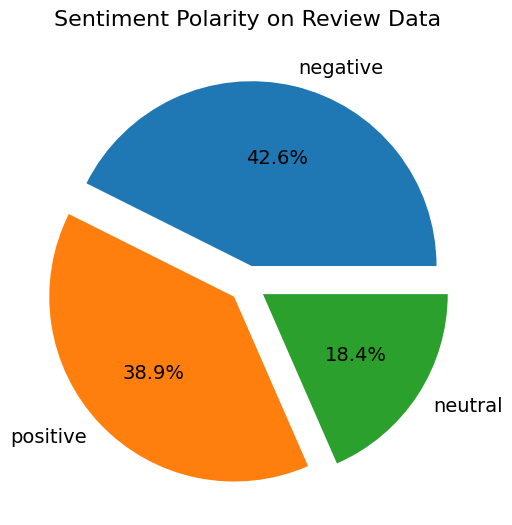

In [29]:
import matplotlib.pyplot as plt

# Membuat objek gambar dan sumbu dengan ukuran (6, 6) inci.
fig, ax = plt.subplots(figsize=(6, 6))

# Mengambil jumlah data polaritas sentimen dari DataFrame 'clean_df' dan menyimpannya dalam list 'sizes'.
sizes = [count for count in clean_df['polarity'].value_counts()]

# Mengambil label atau kategori sentimen dari DataFrame 'clean_df' dan menyimpannya dalam list 'labels'.
labels = list(clean_df['polarity'].value_counts().index)

# Menentukan seberapa jauh potongan dari pie chart akan ditarik (0.1 artinya potongan pertama akan sedikit terpisah).
explode = (0.1, 0.1, 0.1)

# Membuat pie chart dengan data 'sizes', 'labels', dan 'explode' yang telah ditentukan.
# Autopct digunakan untuk menampilkan persentase di dalam setiap potongan pie.
# Textprops digunakan untuk mengatur ukuran font teks dalam pie chart.
ax.pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%', textprops={'fontsize': 14})

# Menetapkan judul untuk pie chart dengan ukuran font dan jarak (padding) tertentu.
ax.set_title('Sentiment Polarity on Review Data', fontsize=16, pad=20)

# Menampilkan pie chart.
plt.show()

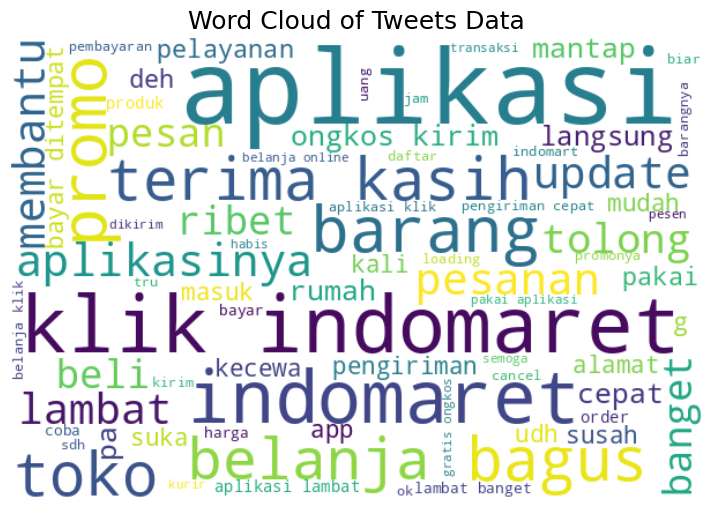

In [30]:
# Menggabungkan semua kata jadi satu list
all_words = []
for tweet in clean_df['text_stopword']:
    all_words.extend(tweet)  # kumpulkan semua kata dari setiap tweet

# Menggabungkan semua kata menjadi satu string
text_for_wordcloud = ' '.join(all_words)

# Membuat WordCloud
wordcloud = WordCloud(
    width=600, height=400,
    background_color='white',
    min_font_size=10
).generate(text_for_wordcloud)

# Menampilkan WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweets Data', fontsize=18)
plt.show()

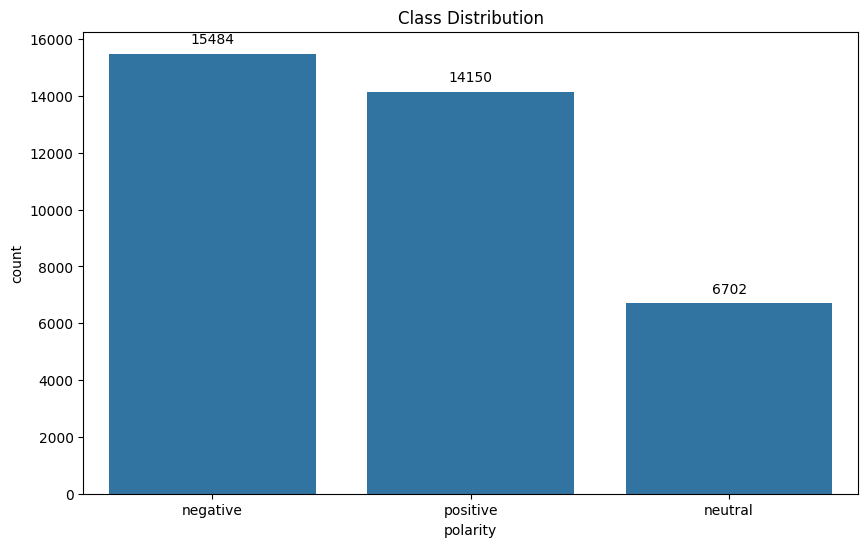

In [31]:
plt.figure(figsize=(10, 6))

# Membuat plot distribusi kelas berdasarkan kolom 'polarity'
class_dist_plot = sns.countplot(x='polarity', data=clean_df)
plt.title('Class Distribution')

# Menambahkan label jumlah di atas setiap batang pada grafik
for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center',
                              xytext=(0, 10),
                              textcoords='offset points')

plt.show()

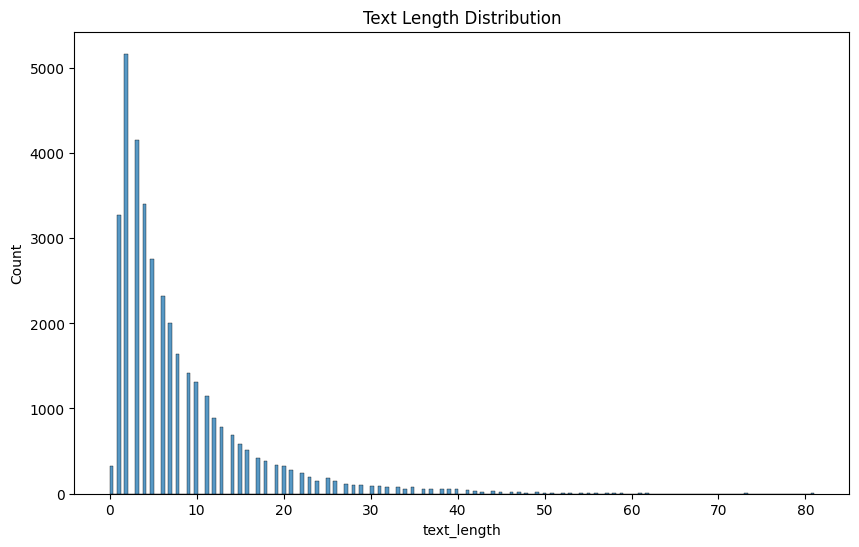

In [32]:
plt.figure(figsize=(10, 6))

# Visualisasi distribusi text length
clean_df['text_length'] = clean_df['text_akhir'].apply(lambda x: len(x.split()))
sns.histplot(clean_df['text_length'])
plt.title('Text Length Distribution')
plt.show()

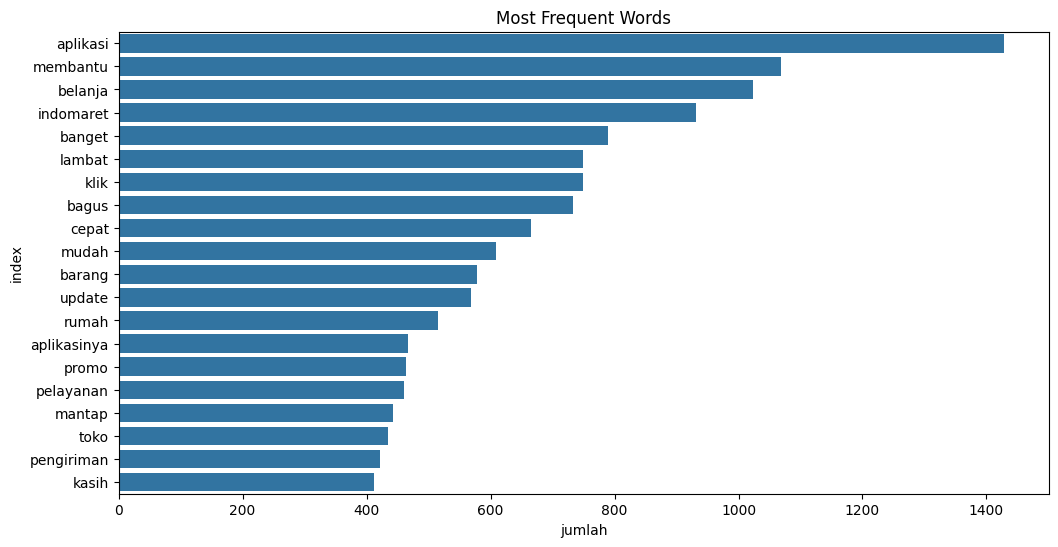

In [33]:
plt.figure(figsize=(12, 6))

# Visualisasi most frequent words
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_df['text_akhir'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)
sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Most Frequent Words')
plt.show()

In [34]:
clean_df.head()

,content,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,polarity_score,polarity,text_length
0,Terimakasih atas kemudahan akses yang diberika...,Terimakasih atas kemudahan akses yang diberika...,terimakasih atas kemudahan akses yang diberika...,terimakasih atas kemudahan akses yang diberika...,"[terimakasih, atas, kemudahan, akses, yang, di...","[terimakasih, kemudahan, akses, aplikasi, klik...",terimakasih kemudahan akses aplikasi klik indo...,-2,negative,45
1,tolong kembalikan versi klik dulu. supaya gamp...,tolong kembalikan versi klik dulu supaya gampa...,tolong kembalikan versi klik dulu supaya gampa...,tolong kembalikan versi klik dulu supaya gampa...,"[tolong, kembalikan, versi, klik, dulu, supaya...","[tolong, kembalikan, versi, klik, gampang, tem...",tolong kembalikan versi klik gampang tempel vo...,5,positive,31
2,"aplikasinya sekarang parah, hari jumat 4 april...",aplikasinya sekarang parah hari jumat april ...,aplikasinya sekarang parah hari jumat april ...,aplikasinya sekarang parah hari jumat april pe...,"[aplikasinya, sekarang, parah, hari, jumat, ap...","[aplikasinya, parah, jumat, april, pesan, kopi...",aplikasinya parah jumat april pesan kopi diaju...,-8,negative,35
3,saya senang dg yg versi lama. bisa filter disk...,saya senang dg yg versi lama bisa filter disko...,saya senang dg yg versi lama bisa filter disko...,saya senang dg yang versi lama bisa filter dis...,"[saya, senang, dg, yang, versi, lama, bisa, fi...","[senang, dg, versi, filter, diskon, tertinggi,...",senang dg versi filter diskon tertinggi urut d...,12,positive,18
4,Bintang nya sy turunin dulu ya krn versi yg ba...,Bintang nya sy turunin dulu ya krn versi yg ba...,bintang nya sy turunin dulu ya krn versi yg ba...,bintang nya saya turunin dulu iya karena versi...,"[bintang, nya, saya, turunin, dulu, iya, karen...","[bintang, turunin, versi, ribet, drpd, versi, ...",bintang turunin versi ribet drpd versi produk ...,6,positive,20


In [35]:
clean_df.shape

(36336, 10)

# Modelling

In [36]:
# Callback Function
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>=0.92):
      print("\nAkurasi mencapai >= 92%!")
      self.model.stop_training = True
callbacks = myCallback()

In [37]:
# Pisahkan data menjadi fitur (tweet) dan label (sentimen)
X = clean_df['text_akhir']
y = clean_df['polarity']

In [38]:
# Tokenisasi
max_features = 5000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X.values)
X_seq = tokenizer.texts_to_sequences(X.values)
X_seq = pad_sequences(X_seq)

# Label Encoding
label_encoder = LabelEncoder()
int_encoded = label_encoder.fit_transform(y)
y_cat = to_categorical(int_encoded)

# Menghitung total jumlah kelas
class_sum = y_cat.shape[1]

## 1. Model LSTM 80/20

In [39]:
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_seq, y_cat, test_size=0.2, random_state=42)

In [40]:
# Mengecek shape dari setiap dataset
print("X_train_lstm:", X_train_lstm.shape)
print("X_test_lstm:", X_test_lstm.shape)

print("y_train_lstm:", y_train_lstm.shape)
print("y_test_lstm:", y_test_lstm.shape)

X_train_lstm: (29068, 78)
X_test_lstm: (7268, 78)
y_train_lstm: (29068, 3)
y_test_lstm: (7268, 3)


In [41]:
# Model LSTM
model_lstm = Sequential([
    Embedding(input_dim=max_features, output_dim=256),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(class_sum, activation='softmax')
])

# Compile
model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Training
history_lstm = model_lstm.fit(
    X_train_lstm,
    y_train_lstm,
    epochs=20,
    batch_size=2056,
    verbose=2,
    callbacks=[callbacks]
)

# Evaluasi
score_lstm, accuracy_lstm = model_lstm.evaluate(
    X_test_lstm, y_test_lstm,
    verbose=2,
    batch_size=1028
)

# Hasil
train_acc_lstm = history_lstm.history['accuracy'][-1]

print("Akurasi Train LSTM: {:.2f}%".format(train_acc_lstm * 100))
print("Akurasi Test LSTM: {:.2f}%".format(accuracy_lstm * 100))

# Simpan
model_lstm.save('model_lstm.h5')

Epoch 1/20
15/15 - 130s - 9s/step - accuracy: 0.4517 - loss: 1.0409
Epoch 2/20
15/15 - 128s - 9s/step - accuracy: 0.6103 - loss: 0.8666
Epoch 3/20
15/15 - 141s - 9s/step - accuracy: 0.7370 - loss: 0.6295
Epoch 4/20
15/15 - 106s - 7s/step - accuracy: 0.8480 - loss: 0.4236
Epoch 5/20
15/15 - 107s - 7s/step - accuracy: 0.8978 - loss: 0.2928
Epoch 6/20

Akurasi mencapai >= 92%!
15/15 - 142s - 9s/step - accuracy: 0.9273 - loss: 0.2112
8/8 - 9s - 1s/step - accuracy: 0.9250 - loss: 0.2297


Akurasi Train LSTM: 92.73%
Akurasi Test LSTM: 92.50%


## 2. Model CNN 80/20

In [42]:
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_seq, y_cat, test_size=0.2, random_state=42)

In [43]:
# Mengecek shape dari setiap dataset
print("X_train_cnn:", X_train_cnn.shape)
print("X_test_cnn:", X_test_cnn.shape)

print("y_train_cnn:", y_train_cnn.shape)
print("y_test_cnn:", y_test_cnn.shape)

X_train_cnn: (29068, 78)
X_test_cnn: (7268, 78)
y_train_cnn: (29068, 3)
y_test_cnn: (7268, 3)


In [48]:
# Model CNN
model_cnn = Sequential([
    Embedding(input_dim=max_features, output_dim=256, input_length=X_seq.shape[1]),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(class_sum, activation='softmax')
])

# Compile
model_cnn.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Training
history_cnn = model_cnn.fit(
    X_train_cnn, y_train_cnn,
    epochs=20,
    batch_size=256,
    verbose=2,
    callbacks=[callbacks]
)

# Evaluasi
score_cnn, accuracy_cnn = model_cnn.evaluate(
    X_test_cnn, y_test_cnn,
    verbose=2,
    batch_size=1028
)

# Hasil
train_acc_cnn = history_cnn.history['accuracy'][-1]

print("Akurasi Train CNN: {:.2f}%".format(train_acc_cnn * 100))
print("Akurasi Test CNN: {:.2f}%".format(accuracy_cnn * 100))

# Simpan hasil
model_cnn.save('model_cnn.h5')

Epoch 1/20
114/114 - 36s - 313ms/step - accuracy: 0.6970 - loss: 0.6877
Epoch 2/20
114/114 - 41s - 361ms/step - accuracy: 0.9145 - loss: 0.2797
Epoch 3/20

Akurasi mencapai >= 92%!
114/114 - 34s - 297ms/step - accuracy: 0.9430 - loss: 0.1846
8/8 - 3s - 386ms/step - accuracy: 0.9201 - loss: 0.2265


Akurasi Train CNN: 94.30%
Akurasi Test CNN: 92.01%


## 3. Model GRU 70/30

In [45]:
X_train_gru, X_test_gru, y_train_gru, y_test_gru = train_test_split(X_seq, y_cat, test_size=0.3, random_state=42)

In [46]:
# Mengecek shape dari setiap dataset
print("X_train_gru:", X_train_gru.shape)
print("X_test_gru:", X_test_gru.shape)

print("y_train_gru:", y_train_gru.shape)
print("y_test_gru:", y_test_gru.shape)

X_train_gru: (25435, 78)
X_test_gru: (10901, 78)
y_train_gru: (25435, 3)
y_test_gru: (10901, 3)


In [47]:
# Model GRU
model_gru = Sequential([
    Embedding(input_dim=max_features, output_dim=256, input_length=X_seq.shape[1]),
    SpatialDropout1D(0.3),
    Bidirectional(GRU(64, return_sequences=True)),
    Bidirectional(GRU(128, return_sequences=False)),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(class_sum, activation='softmax')
])

# Compile
model_gru.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Training
history_gru = model_gru.fit(
    X_train_gru, y_train_gru,
    epochs=20,
    batch_size=2056,
    verbose=2,
    callbacks=[callbacks]
)

# Evaluasi
score_gru, accuracy_gru = model_gru.evaluate(
    X_test_gru, y_test_gru,
    verbose=2,
    batch_size=1028
)

# Hasil
train_acc_gru = history_gru.history['accuracy'][-1]

print("Akurasi Train GRU: {:.2f}%".format(train_acc_gru * 100))
print("Akurasi Test GRU: {:.2f}%".format(accuracy_gru * 100))

# Simpan hasil
model_gru.save('model_gru.h5')

Epoch 1/20
13/13 - 155s - 12s/step - accuracy: 0.4516 - loss: 3.2989
Epoch 2/20
13/13 - 143s - 11s/step - accuracy: 0.6329 - loss: 2.5476
Epoch 3/20
13/13 - 202s - 16s/step - accuracy: 0.8100 - loss: 1.8385
Epoch 4/20
13/13 - 200s - 15s/step - accuracy: 0.8944 - loss: 1.3095
Epoch 5/20

Akurasi mencapai >= 92%!
13/13 - 146s - 11s/step - accuracy: 0.9277 - loss: 0.9624
11/11 - 18s - 2s/step - accuracy: 0.9157 - loss: 0.8681


Akurasi Train GRU: 92.77%
Akurasi Test GRU: 91.57%


# Testing

In [51]:
# Perbandingan akurasi 3 skema pelatihan
comparison = pd.DataFrame({
    'Model Name': ['LSTM', 'CNN', 'GRU'],
    'Training Accuracy': [
        history_lstm.history['accuracy'][-1],
        history_cnn.history['accuracy'][-1],
        history_gru.history['accuracy'][-1]
    ],
    'Testing Accuracy': [accuracy_lstm, accuracy_cnn, accuracy_gru]
})

comparison

,Model Name,Training Accuracy,Testing Accuracy
0,LSTM,0.927308,0.925014
1,CNN,0.942996,0.920061
2,GRU,0.927737,0.915696


In [102]:
# Data baru
new_texts = [
    "Aplikasinya sangat membantu, tinggal klik barang langsung sampai rumah. Cepat dan praktis banget!",
    "Sering error pas checkout, dan customer service susah dihubungi.",
    "Cukup membantu, tapi pesanan lama sampai."
]

# Nilai asli teks
true_labels = ["positive", "negative", "neutral"]

# Tokenisasi teks baru
new_seq = tokenizer.texts_to_sequences(new_texts)
new_seq_padded = pad_sequences(new_seq, maxlen=X_seq.shape[1])

# Membuat prediksi berdasarkan model
predic_lstm = model_lstm.predict(new_seq_padded)
predic_cnn = model_cnn.predict(new_seq_padded)
predic_gru = model_gru.predict(new_seq_padded)

# Mengubah prediksi menjadi label
predic_labels_lstm = label_encoder.inverse_transform(np.argmax(predic_lstm, axis=1))
predic_labels_cnn = label_encoder.inverse_transform(np.argmax(predic_cnn, axis=1))
predic_labels_gru = label_encoder.inverse_transform(np.argmax(predic_gru, axis=1))

# Menampilkan hasil dari prediksi
for text, true_label, label_lstm, label_cnn, label_gru in zip(new_texts, true_labels, predic_labels_lstm, predic_labels_cnn, predic_labels_gru):
    print(f"Text: {text}\nTrue Label: {true_label}\nPredicted Label (LSTM): {label_lstm}\nPredicted Label (CNN): {label_cnn}\nPredicted Label (GRU): {label_gru}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Text: Aplikasinya sangat membantu, tinggal klik barang langsung sampai rumah. Cepat dan praktis banget!
True Label: positive
Predicted Label (LSTM): positive
Predicted Label (CNN): positive
Predicted Label (GRU): positive

Text: Sering error pas checkout, dan customer service susah dihubungi.
True Label: negative
Predicted Label (LSTM): negative
Predicted Label (CNN): negative
Predicted Label (GRU): negative

Text: Cukup membantu, tapi pesanan lama sampai.
True Label: neutral
Predicted Label (LSTM): neutral
Predicted Label (CNN): neutral
Predicted Label (GRU): neutral



In [103]:
!pip freeze requirements.txt

absl-py==1.4.0
accelerate==1.5.2
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.5
ale-py==0.10.2
altair==5.5.0
annotated-types==0.7.0
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.1
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.4.7.0.35.30
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.3
betterproto==2.0.0b6
bigframes==1.42.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blosc2==3.3.0
bokeh==3.6.3
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
CacheControl==0.14.2
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.1.31
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.89
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confec